# Implementation of Generalized Fisherface

## Baseline Fisherface

In [1]:
import numpy as np

import torch
from torch import nn
import torch.optim

from sklearn.decomposition import PCA

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

NOTE: OPTIMIZATION SEEMS TO BE SOMEHOW NOT WELL POSED. WHY? NO BOUNDS, LOSS IS ARBITRARILY SMALL / MAXIMIZATION ARBITRARILY LARGE

Q: Is fisherace omitting some details about the optimization? what's to stop us from getting arbitrarily low loss through an arbitrarily large matrix? is the optimization supposed to be over matrices with columns with unit length? If so, how can I turn this into an unconstrained optimization problem so that I can use gradient descent or similar optimization algorithms?

# PCA (via Gradient Decent)

In [ ]:
np.random.random(size)

In [147]:
class myPCA():
    '''An implementation of PCA using gradient decent'''
    # used for debugging implementation of generalized fisherface...
    def __init__(self, X, n_components, optimizer=torch.optim.Adam, regularization_func=torch.linalg.matrix_norm,
                    lr=1e-2, n_steps=100, l2_coef=1, stop_thres=1e-3, verbose=True, **optim_kwargs):

        self.n_samples = np.shape(X)[0]
        self.dim = np.shape(X)[1]
        self.n_components = n_components

        self.l2_coef = l2_coef
        self.regularization_func = regularization_func

        self.stop_thres = stop_thres

        W = torch.eye(self.dim, self.n_components) # (dim x n_compoenents) matrix
        self.W = nn.Parameter(W)

        # NOTE: we assume normalization prior to calling this...
        global_mean = np.mean(X, axis=0)

        # compute total scatter matrix
        self.S_T = (X - global_mean).T @ (X - global_mean)
        # self.S_T = np.cov(X.T)# NOTE TEMP
        self.S_T = torch.tensor(self.S_T, dtype=torch.float32)

        self.optimizer = optimizer([self.W], lr=lr, **optim_kwargs)
        self.n_steps = n_steps
        self.loss_history = []
        self.objective_history = []

    def base_objective_func(self, W):
        return torch.det(W.t() @ self.S_T @ W)

    def loss(self):
        # (negative since we're maximizing) + L2 regularization to implement constrained optimization (NOTE TEMP experimentating)
        loss = - self.base_objective_func(self.W) + self.l2_coef * self.regularization_func(self.W)
        return loss

    def normalized_W(self):
        return self.W / torch.sqrt(torch.sum(self.W**2, axis=0))

    @property
    def W_opt(self):
        '''returns normalized transformation matrix'''
        return self.normalized_W()

    def fit(self, X=None, y=None, n_steps=None):
        if n_steps is None:
            n_steps = self.n_steps

        print('Fitting transformation...')
        obj_prev = self.base_objective_func(self.W_opt).detach().numpy()
        for _ in tqdm(range(n_steps)):
            self.optimizer.zero_grad()
            loss = self.loss()
            loss.backward()
            self.optimizer.step()
            self.loss_history.append(loss.detach().numpy())

            objective = self.base_objective_func(self.W_opt).detach().numpy()
            self.objective_history.append(objective)

            if self.stop_thres is not None:
                if np.max(np.abs(obj_prev - objective)) < self.stop_thres:
                    print('Early stopping.')
                    break

                obj_prev = self.base_objective_func(self.W_opt).detach().numpy()



    def transform(self, X):
        return self.W_opt.t() @ X

In [148]:
n_samples = 1000
dim = 64*64
n_classes = 6
n_components = 5

# X1 = np.random.uniform(size=n_samples)
# X2 = 2*X1 + 0.2*np.random.normal(size=n_samples)
# X = np.array((X1, X2)).T

X = np.random.uniform(size=(n_samples, dim))
y = np.random.randint(0, n_classes-1, size=n_samples)

In [149]:
X.shape

(1000, 4096)

In [150]:
pca = myPCA(X, n_components, optimizer=torch.optim.Adam, lr=1e-2, l2_coef=2, regularization_func=lambda x: torch.linalg.matrix_norm(x, ord=2))

In [151]:
pca.fit(n_steps=1000)

Fitting transformation...


 10%|▉         | 98/1000 [00:06<00:56, 15.99it/s]

Early stopping.


In [152]:
pca.W_opt

tensor([[ 0.0895, -0.0156,  0.0115,  0.0122,  0.0144],
        [-0.0130,  0.0907, -0.0132,  0.0249, -0.0137],
        [ 0.0190, -0.0156,  0.0907,  0.0376, -0.0180],
        ...,
        [ 0.0112, -0.0131, -0.0147, -0.0125,  0.0137],
        [ 0.0137, -0.0148,  0.0131,  0.0236,  0.0238],
        [-0.0145, -0.0140,  0.0125, -0.0117, -0.0137]], grad_fn=<DivBackward0>)

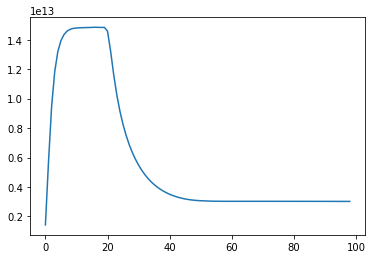

In [153]:
plt.plot(pca.objective_history)

In [137]:
pca.W_opt.t() @ pca.W_opt # W_opt is indeed orthonormal...

tensor([[1.0000, 0.7428, 0.7430, 0.7375, 0.7491],
        [0.7428, 1.0000, 0.7493, 0.7447, 0.7451],
        [0.7430, 0.7493, 1.0000, 0.7487, 0.7469],
        [0.7375, 0.7447, 0.7487, 1.0000, 0.7439],
        [0.7491, 0.7451, 0.7469, 0.7439, 1.0000]], grad_fn=<MmBackward0>)

In [138]:
W = PCA(n_components=n_components).fit(X).components_.T # get the transformation obtained by sklearn's PCA

In [139]:
print(W) # but is different from the transformation obtained via PCA; but it might be 'equivalent'? perhaps same 'subspace'

[[-0.01384515  0.00303829  0.00909934 -0.01460447  0.00030356]
 [ 0.00841382 -0.01088396  0.00582504 -0.00083669  0.00919841]
 [ 0.01105549  0.00057353 -0.00415466  0.00196091  0.02031142]
 ...
 [ 0.02514635 -0.01860873 -0.02597897 -0.00851558 -0.00148205]
 [ 0.00954915 -0.00758734  0.01445983  0.01061876 -0.01338196]
 [ 0.01323342  0.00599086 -0.00043872  0.01750647  0.0282344 ]]


In [140]:
pca.base_objective_func(torch.tensor(W, dtype=torch.float32))

tensor(1.8784e+14)

In [141]:
pca.base_objective_func(pca.W_opt)

tensor(69316736., grad_fn=<DetLuBasedHelperBackward0>)

the results from sklearn's PCA are different. but sklearn's PCA is different each time you run it. how can we validate that the results are 'equivalent'?? compare subspaces?? compare loss?

the loss obtained by sklearn's PCA implementation is consistently the same even though the `components_` differ.

my implementation doesn't achieve as high a maximization as sklearn's PCA... why?

sometimes the `objective_loss` goes up then back down => the loss function doesn't maximize the objective over orthonormal matrices... the objective is highly dependent on the initialization (if i initialize with identity the objective achieved is different than if randomly initialized).

actually, for a simple example, my implementation achieaves the exact same loss... is there some kind of instability going on? convergence is achieved for simple examples but for more complicated ones? confirm: this is a convex optimization problem right? should i be looking into optimization algorithms other than gradient decent-based ones.

# Fisherface

In [142]:
class Fisherface():
    def __init__(self, X, y, n_components=None, pca_first=True, verbose=True, S_B=None, S_W=None):

        self.n_samples = np.shape(X)[0]
        self.dim = np.shape(X)[1]

        self.n_classes = len(np.unique(y))


        # set default number components to be number of classes - 1 (if no other number given)
        if n_components is None:
            # this is the maximum number of components s.t. S_W is non-singular
            self.n_components = self.n_classes - 1
        else:
            self.n_components = n_components

        if pca_first:
            # perform PCA first to address S_W, the within-class scatter matrix, being singular

            # the PCA matrix
            if verbose:
                print('Performing PCA for initial dimensionality reduction')
            pca = PCA(n_components=self.n_samples - self.n_classes).fit(X)
            self.W_pca = torch.tensor(pca.components_.T, dtype=torch.float32) # (dim x n_samples - n_classes) matrix
            if verbose:
                print('Done.')

            # the fisher's linear discriminant matrix
            # TODO: consider what the best choice for intialization would be.
            W_fld = torch.eye(self.n_samples - self.n_classes, self.n_components) \
                    + torch.rand(self.n_samples - self.n_classes, self.n_components) # (n_samples - n_classes x n_compoenents) matrix
            self.W_fld = nn.Parameter(W_fld)

        else:
            # don't perform PCA, perform standard fisher's linear discriminant
            self.W_pca = torch.eye(self.dim)

            W_fld = torch.Tensor(self.n_samples - self.n_classes, self.n_components) # (n_samples - n_classes x n_compoenents) matrix
            self.W_fld = nn.Parameter(W_fld)


        # NOTE: we assume normalization prior to calling this...
        classes = np.sort(np.unique(y)) # classes in the dataset
        points_by_class = [X[y==class_] for class_ in classes] # the sets X_i
        n_points_by_class = [len(X[y==class_]) for class_ in classes]
        class_means = [np.mean(class_points, axis=0) for class_points in points_by_class] # mu_i's
        global_mean = np.expand_dims(np.mean(X, axis=0),-1)

        # between-class scatter matrix
        if verbose:
            print('Computing the between-class and within-class scatter matrices...')

        # allow for precomputing S_B and S_W for faster debugging
        if S_B is None or S_W is None:
            self.S_B = np.sum([n_points_by_class[class_] * (class_means[class_] - global_mean).T @ (class_means[class_] - global_mean) for class_ in classes], axis=0)
            self.S_W = np.sum([(points_by_class[class_] - class_means[class_]).T @ (points_by_class[class_] - class_means[class_]) for class_ in classes], axis=0)
        else:
            self.S_B = S_B
            self.S_W = S_W

        self.S_B = torch.tensor(self.S_B, dtype=torch.float32)
        self.S_W = torch.tensor(self.S_W, dtype=torch.float32)
        if verbose:
            print('Done.')


    def loss(self):
        numerator = torch.det(self.W_fld.t() @ self.W_pca.t() @ self.S_B @ self.W_pca @ self.W_fld)
        denominator = torch.det(self.W_fld.t() @ self.W_pca.t() @ self.S_W @ self.W_pca @ self.W_fld)
        loss = - numerator / denominator # (negative since we're maximizing)
        return loss

    @property
    def W_opt(self):
        return self.W_pca @ self.W_fld

    def fit(self, X, y):
        pass

    def transform(self, X):
        pass

In [143]:
S_B = fld.S_B.detach().numpy()
S_W = fld.S_W.detach().numpy()

In [51]:
n_samples = 1000
dim = 64*64
n_classes = 6
n_components = 5

X = np.random.uniform(size=(n_samples, dim))
y = np.random.randint(0, n_classes-1, size=n_samples)

# fld = Fisherface(X, y, n_components=n_components, pca_first=True)

In [164]:
fld = Fisherface(X, y, n_components=n_components, pca_first=True, S_B=S_B, S_W=S_W)

Performing PCA for initial dimensionality reduction
Done.
Computing the between-class and within-class scatter matrices...
Done.


In [167]:
loss = fld.loss()
loss.backward()
fld.W_fld.grad

tensor([[ 61853.2500, -52495.2578, -39789.2031,  13971.1719, -21186.1426],
        [ -5974.6821,   8014.5391,  10462.8730,   2579.0161,  -3760.1821],
        [ 10566.6855, -35335.0898, -19384.4062,   2742.2375,   4167.3550],
        ...,
        [-11012.6816,   7640.9126,  13530.7695,  -8384.8271,   6211.9663],
        [ 14166.7910, -30040.1055, -10209.0518,   2564.4790,  -1195.6466],
        [ 24937.6035, -18554.4766, -13991.1953,  -3230.4907,  -7145.3887]])

In [169]:
fld.W_fld

Parameter containing:
tensor([[1.2030, 0.1466, 0.0552, 0.3083, 0.6972],
        [0.6202, 1.8754, 0.2999, 0.8033, 0.2063],
        [0.7881, 0.0266, 1.0428, 0.4321, 0.4302],
        ...,
        [0.6960, 0.2532, 0.1509, 0.1046, 0.1454],
        [0.8285, 0.1132, 0.5184, 0.6016, 0.3878],
        [0.7546, 0.6600, 0.0294, 0.3034, 0.6303]], requires_grad=True)

In [173]:
n_steps = int(1e2)
optimizer = torch.optim.SGD([fld.W_fld], lr=1e-10)
loss_history = []


for _ in tqdm(range(n_steps)):
    optimizer.zero_grad()
    loss = fld.loss()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().numpy())

100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


In [174]:
loss_history

[array(-98863.695, dtype=float32),
 array(-99451.12, dtype=float32),
 array(-100042.71, dtype=float32),
 array(-100643.08, dtype=float32),
 array(-101239.836, dtype=float32),
 array(-101846.47, dtype=float32),
 array(-102453.01, dtype=float32),
 array(-103061.99, dtype=float32),
 array(-103679., dtype=float32),
 array(-104297.48, dtype=float32),
 array(-104920.69, dtype=float32),
 array(-105559.375, dtype=float32),
 array(-106183.84, dtype=float32),
 array(-106816.484, dtype=float32),
 array(-107460.91, dtype=float32),
 array(-108106.38, dtype=float32),
 array(-108752.016, dtype=float32),
 array(-109408.51, dtype=float32),
 array(-110066.05, dtype=float32),
 array(-110721.4, dtype=float32),
 array(-111395.96, dtype=float32),
 array(-112067.125, dtype=float32),
 array(-112738.445, dtype=float32),
 array(-113422.195, dtype=float32),
 array(-114103.32, dtype=float32),
 array(-114793.85, dtype=float32),
 array(-115487.945, dtype=float32),
 array(-116189.01, dtype=float32),
 array(-116891.5

In [83]:
fld.W_fld

Parameter containing:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], requires_grad=True)